# Spam or Ham Project

## Imports

In [71]:
# Imports

import kagglehub
import pandas as pd
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from dython.nominal import associations
from nltk import FreqDist


In [2]:
# Download CSV

path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

df = pd.read_csv(path + '\\spam.csv', usecols=['v1', 'v2'], encoding = 'latin-1')

df.to_csv()

Path to dataset files: C:\Users\nick_\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1


In [ ]:
import chardet

# Method 1: Detect encoding of an entire file
def detect_file_encoding(file_path):
    # Read the file in binary mode
    with open(file_path, 'rb') as file:
        # Read the raw bytes
        raw_data = file.read()

        # Detect encoding
        result = chardet.detect(raw_data)

        return result

# Example usage
file_path = 'your_file.csv'  # Replace with your file path
encoding_info = detect_file_encoding(file_path)
print(f"Detected encoding: {encoding_info}")

## General Clean and Train/Test Split

In [3]:
# head check

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Shape check

df.shape

(5572, 2)

In [5]:
# Nan check

df.isna().sum()

v1    0
v2    0
dtype: int64

In [6]:
# Check for dupes

df.duplicated().sum()

np.int64(403)

In [8]:
# Drop dupes

df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [9]:
# Info check

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   object
 1   v2      5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


**Will run cross-validation due to small size of datasets. Splitting before any EDA is done**

In [13]:
# train test split

X = df['v2'].copy()
y = df['v1'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4393,) (4393,)
(776,) (776,)


In [16]:
# check target column

y_train.head()

422      ham
1962    spam
2492     ham
5475     ham
825      ham
Name: v1, dtype: object

## EDA

In [18]:
# Combine train sets for EDA

df_eda = pd.concat([X_train, y_train], axis=1)

df_eda

,v2,v1
422,Siva is in hostel aha:-.,ham
1962,it to 80488. Your 500 free text messages are v...,spam
2492,No drama Pls.i have had enough from you and fa...,ham
5475,Dhoni have luck to win some big title.so we wi...,ham
825,Hmm .. Bits and pieces lol ... *sighs* ...,ham
...,...,...
4740,Many more happy returns of the day. I wish you...,ham
474,Nice line said by a broken heart- Plz don't cu...,ham
3266,Ok then i come n pick u at engin?,ham
4016,Eek that's a lot of time especially since Amer...,ham


In [20]:
# Create character count column

df_eda['char_count'] = df_eda['v2'].str.len()
df_eda.head()

,v2,v1,char_count
422,Siva is in hostel aha:-.,ham,24
1962,it to 80488. Your 500 free text messages are v...,spam,74
2492,No drama Pls.i have had enough from you and fa...,ham,245
5475,Dhoni have luck to win some big title.so we wi...,ham,54
825,Hmm .. Bits and pieces lol ... *sighs* ...,ham,42


In [39]:
# Create word count column

df_eda['word_count'] = df_eda['v2'].str.split().str.len()
df_eda.head()

,v2,v1,char_count,word_count
422,Siva is in hostel aha:-.,ham,24,5
1962,it to 80488. Your 500 free text messages are v...,spam,74,14
2492,No drama Pls.i have had enough from you and fa...,ham,245,45
5475,Dhoni have luck to win some big title.so we wi...,ham,54,11
825,Hmm .. Bits and pieces lol ... *sighs* ...,ham,42,9


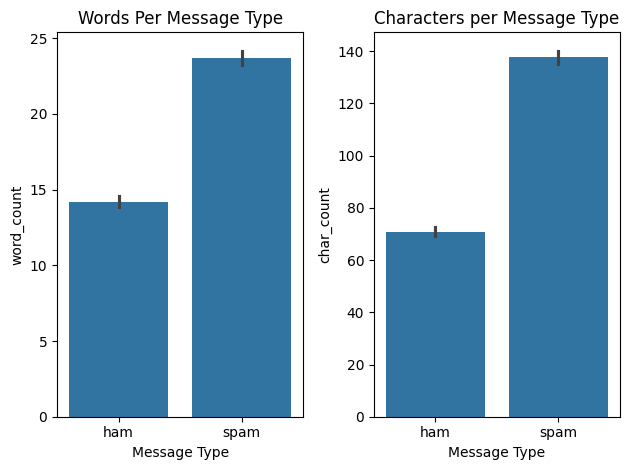

In [62]:
# Create barplots with average counts per target

fig, ax = plt.subplots(1,2)
sns.barplot(data=df_eda, x='v1', y = 'word_count', estimator=np.mean, ax=ax[0])
sns.barplot(data=df_eda, x='v1', y = 'char_count', estimator=np.mean, ax=ax[1])
ax[0].set_title('Words Per Message Type')
ax[1].set_title('Characters per Message Type')
ax[0].set_xlabel('Message Type')
ax[1].set_xlabel('Message Type')
plt.tight_layout();

In [72]:
# Look at numbers for word count

(((df_eda[df_eda['v1'] == 'spam']['word_count'].mean()) - (df_eda[df_eda['v1'] == 'ham']['word_count'].mean()))

/

((df_eda[df_eda['v1'] == 'ham']['word_count'].mean())))

np.float64(0.6683512150105875)

**In our train dataset, average spam word counts are 66% higher than average ham word counts**

Next I will look at frequency distributions of lemmas for each category

In [74]:
# Create model for preprocessing

nlp = spacy.load('en_core_web_sm')

In [80]:
# Loop to preprocess all words and create new column

processed_text = []
counter = 1

for doc in nlp.pipe(df_eda['v2'], batch_size=1000, n_process=-1, disable=['ner', 'parser']):
  print(counter)
  counter += 1
  processed_text.append([token.lemma_.lower() for token in doc
                        if not token.is_stop
                        and not token.is_punct
                        and not token.is_space])

df_eda['spacy_tokens'] = processed_text

df_eda.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,v2,v1,char_count,word_count,spacy_tokens
422,Siva is in hostel aha:-.,ham,24,5,"[siva, hostel, aha:-]"
1962,it to 80488. Your 500 free text messages are v...,spam,74,14,"[80488, 500, free, text, message, valid, 31, d..."
2492,No drama Pls.i have had enough from you and fa...,ham,245,45,"[drama, pls.i, family, struggle, hot, sun, str..."
5475,Dhoni have luck to win some big title.so we wi...,ham,54,11,"[dhoni, luck, win, big, title.so, win]"
825,Hmm .. Bits and pieces lol ... *sighs* ...,ham,42,9,"[hmm, bit, piece, lol, sigh]"


In [81]:
# create ham and spam dfs to combine all into one string for frequency distribution

ha = df_eda[df_eda['v1'] == 'ham']
spa = df_eda[df_eda['v1'] == 'spam']

In [82]:
# Get lemmas into format that freq dist can use

ha_words = ha['spacy_tokens'].explode().astype(str).to_list()
ha_words = ' '.join(ha_words)
ha_words

'siva hostel aha:- drama pls.i family struggle hot sun strange place reason ego go invite actually necessity go.wait reppurcussion dhoni luck win big title.so win hmm bit piece lol sigh nope b go 2 sch fri early lor cos mys sis get paper da morn think \\what u got\\ think \\"how use got\\ good ni8 hide anythiing keep distance sure night menu know noon menu eh u remember 2 spell yes v naughty v wet random see old roomate campus graduate lol boo hope laugh spend day wait ideal path appear forget \\path walk wait goodnight care n soon day billion class right jesus christ bitch try drug answer fucking phone watch movie xy want 2 shop shop w search 4 happiness 1 d main source unhappiness accept life way come u find happiness moment u live wish thing different wonder able value pls continue brisk walk drug askin find thing laugh love dearly payasam rinu bring u texte finish long time ago shower er\'ythe leave de:- start prepare next:- mean not wait u get bored bridgwater banter dear cherthal

In [83]:
# Get lemmas into format that freq dist can use

spa_words = spa['spacy_tokens'].explode().astype(str).to_list()
spa_words = ' '.join(spa_words)
spa_words

"80488 500 free text message valid 31 december 2005 urgent 09061743810 landline abta complimentary 4 tenerife holiday 5000 cash await collection sae t&c box 326 cw25wx 150 ppm eerie nokia tone 4u rply tone title 8007 eg tone dracula 8007 titles ghost addamsfa munsters exorcist twilight www.getzed.co.uk pobox36504w45wq 150p sms auction brand new nokia 7250 4 auction today auction free 2 join txt nokia 86021 85233 free > ringtone!reply real win 1,000 cash 2,000 prize claim call09050000327 stop club tone reply \\stop mix\\ my-tone.com/enjoy html term club tone cost gbp4.50 week mfl romantic paris 2 night 2 flight å£79 book 4 year 08704439680ts&cs apply sim subscriber select receive bonus deliver door txt word ok 88600 claim 150p msg exp 30apr freemsg hey buffy 25 love satisfy man home feel randy reply 2 c pix qlynnbv help08700621170150p msg send stop stop txts free msg single find partner area 1000 real people wait chat now!send chat 62220cncl send stopcs 08717890890å£1.50 msg married loc

In [84]:
ha_freq = FreqDist(ha_words.split())
spa_freq = FreqDist(spa_words.split())
spa_freq

FreqDist({'free': 161, '2': 136, 'txt': 111, 'text': 102, 'ur': 100, 'mobile': 100, 'stop': 88, 'u': 88, '4': 82, 'claim': 81, ...})

In [88]:
ha_freq['lt;#&gt']

227

<Axes: title={'center': 'Most Common Words in Ham Texts'}, xlabel='Samples', ylabel='Counts'>

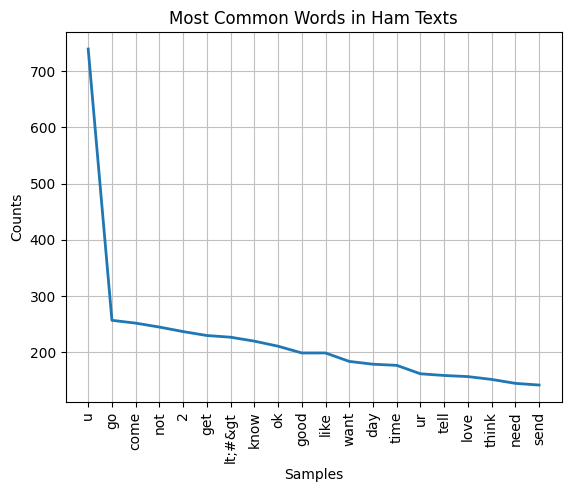

In [85]:
ha_freq.plot(20, title='Most Common Words in Ham Texts')

<Axes: title={'center': 'Most Common Words in Spam Texts'}, xlabel='Samples', ylabel='Counts'>

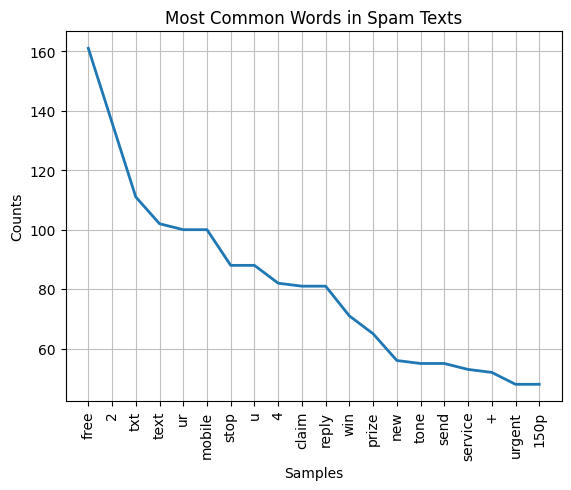

In [87]:
spa_freq.plot(20, title='Most Common Words in Spam Texts')